In [1]:
path = "../data/"
csvfile = "Pdu_biofilm_bacteria_diatom_experiment.csv"

#import pandas
import pandas as pd
# import matplotlib
import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
%matplotlib inline
df = pd.read_csv(path+csvfile)
print(df)
df.head()
df.info()

     age  time_after_induction                           Treatment  \
0    3.5                    12  Pseuduoalteromonas shioyasakiensis   
1    3.5                    12  Pseuduoalteromonas shioyasakiensis   
2    3.5                    12  Pseuduoalteromonas shioyasakiensis   
3    3.5                    12  Pseuduoalteromonas shioyasakiensis   
4    3.5                    12               Halobacillus sp. G-12   
..   ...                   ...                                 ...   
187  6.0                    72                 Skeletonema dohrnii   
188  6.0                    72                       Mixed biofilm   
189  6.0                    72                       Mixed biofilm   
190  6.0                    72                       Mixed biofilm   
191  6.0                    72                       Mixed biofilm   

    Abbreviation  crawl_coverslip  %_crawl_coverslip  
0          P.shi                1           3.333333  
1          P.shi                0           0.000

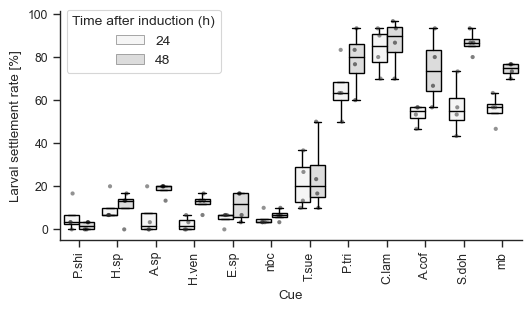

In [22]:
#Get ready to plot 
sns.set(font="Arial")
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1)

#Make a neutral palette
# color palette as dictionary
mypalette = {24:"whitesmoke", 48:"gainsboro"}


#Data subset for 24 and 48 hpi
time_2448 = df[(df['time_after_induction']==24) | (df['time_after_induction']==48)]

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}


grped_bplot = sns.catplot(x='Abbreviation', 
                          y='%_crawl_coverslip',
                          hue="time_after_induction",
                          kind="box",
                          legend=False,
                          height=3, 
                          aspect=1.8,
                          palette= mypalette,
                          data=time_2448,
                          fliersize=0,
                          linewidth=1.0,
                         **PROPS);

# make grouped stripplot
grped_bplot = sns.stripplot(x='Abbreviation', 
                            y='%_crawl_coverslip', 
                            hue='time_after_induction',
                            jitter=True,
                            dodge=True, 
                            marker='o', 
                            palette='dark:black',
                            alpha=0.5,
                            size=3,
                            data=time_2448)
# how to remove redundant legends in Python
# Let us first get legend information from the plot object
handles, labels = grped_bplot.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:2], labels[0:2], loc='upper left')


#sns.despine()
bplot.set_ylim(0, 100)
plt.xlabel("Cue")
plt.ylabel("Larval settlement rate [%]")
plt.xticks(rotation=90)

sns.move_legend(
    grped_bplot, "lower left",
    bbox_to_anchor=(0, 0.7), ncol=1, title='Time after induction (h)', frameon=True, fontsize=10, title_fontsize=10
)



#Export graph to an svg file for use in figure 
plt.savefig("../output/fig1b.svg", bbox_inches='tight')

In [23]:
print(time_2448["time_after_induction"])

48     24
49     24
50     24
51     24
52     24
       ..
139    48
140    48
141    48
142    48
143    48
Name: time_after_induction, Length: 96, dtype: int64


In [24]:
#Run a Shapiro-Wilks test on data to check distribution
#import libraries needed
import numpy as np
from scipy.stats import shapiro
from numpy.random import random

#Conduct the Shapiro-Wilk Test
shapiro(df["%_crawl_coverslip"])
#The test rejects the hypothesis of normality when the p-value is less than or equal to 0.05. We can state with 95% confidence that the data does NOT fit the normal distribution. 

ShapiroResult(statistic=0.8860740661621094, pvalue=6.668055690939312e-11)

In [25]:
#We want to know if each type of bacteria or microlgae used causes significantly more settlement than control, after 24 and 48h.
#We will do Mann-Whitney U rank test on each treatment vs control to check for p-value <0.05, at 24 and 48h.

from scipy import stats

#test subsetting the data correctly for 24h control and other treatments
print(df["%_crawl_coverslip"][(df['time_after_induction']==24) & (df['Treatment'] == "No biofilm control")])
print(np.unique(df['Treatment']))

#make a dictionary called 'p-values' and output into it the results of a Mann-Whitney U test on each treatment vs control, 24h
p_values= {}
ctrl_data = df["%_crawl_coverslip"][(df['time_after_induction']==24) & (df['Treatment'] == "No biofilm control")]
for treatment in np.unique(df['Treatment']):
    test_data = df["%_crawl_coverslip"][(df['time_after_induction']==24) & (df['Treatment'] == treatment)]
    print(treatment)
    res = stats.mannwhitneyu(ctrl_data, test_data)
    print(res)
    p_values[treatment] = res[1]

#make a dictionary called 'p-values48' and output into it the results of a Mann-Whitney U test on each treatment vs control, 48h
p_values48= {}
ctrl_data48 = df["%_crawl_coverslip"][(df['time_after_induction']==48) & (df['Treatment'] == "No biofilm control")]
for treatment in np.unique(df['Treatment']):
    test_data48 = df["%_crawl_coverslip"][(df['time_after_induction']==48) & (df['Treatment'] == treatment)]
    print(treatment)
    res48 = stats.mannwhitneyu(ctrl_data48, test_data48)
    print(res48)
    p_values48[treatment] = res48[1]
    
#combine the two dictionaries for 24 and 48h into one dictionary
def mergeDictionary(p_values, P_values48):
   dict_both = {**p_values, **p_values48}
   for key, value in dict_both.items():
       if key in p_values and key in P_values48:
               dict_both[key] = [value , p_values[key]]
   return dict_both

dict_both = mergeDictionary(p_values, p_values48)
print(dict_both)

#make a dataframe from this dictionary
MW_results = pd.DataFrame.from_dict(dict_both, orient='index',
                       columns=['24h p-value', '48h p-value'])
MW_results_sorted = MW_results.sort_values(by='48h p-value', ascending=False)
MWresults_html = MW_results_sorted.style.set_caption('Table S1. Mann-Whitney U rank test p-values for different cues vs negative control')

#Save to file
MW_results_sorted.to_csv("../output/SuppTable_for_fig1b.csv")
MWresults_html.to_html("../output/SuppTable_for_fig1b.html")

68     3.333333
69     3.333333
70    10.000000
71     3.333333
Name: %_crawl_coverslip, dtype: float64
['Alteromonas sp. strain JLT1934' 'Amphora coffeaeformis'
 'Chrysotila lamellosa' 'Exiguobacterium sp. WR-24'
 'Halobacillus sp. G-12' 'Halomonas venusta' 'Mixed biofilm'
 'No biofilm control' 'Phaeodactylum tricornutum'
 'Pseuduoalteromonas shioyasakiensis' 'Skeletonema dohrnii'
 'Tetraselmis suecica']
Alteromonas sp. strain JLT1934
MannwhitneyuResult(statistic=10.5, pvalue=0.5357032416623113)
Amphora coffeaeformis
MannwhitneyuResult(statistic=0.0, pvalue=0.025580146726954023)
Chrysotila lamellosa
MannwhitneyuResult(statistic=0.0, pvalue=0.026518721959430728)
Exiguobacterium sp. WR-24
MannwhitneyuResult(statistic=7.0, pvalue=0.8793886590272973)
Halobacillus sp. G-12
MannwhitneyuResult(statistic=3.0, pvalue=0.1720337089218229)
Halomonas venusta
MannwhitneyuResult(statistic=11.5, pvalue=0.35289670147688934)
Mixed biofilm
MannwhitneyuResult(statistic=0.0, pvalue=0.025580146726954023)
N

In [26]:
print(p_values)

{'Alteromonas sp. strain JLT1934': 0.5357032416623113, 'Amphora coffeaeformis': 0.025580146726954023, 'Chrysotila lamellosa': 0.026518721959430728, 'Exiguobacterium sp. WR-24': 0.8793886590272973, 'Halobacillus sp. G-12': 0.1720337089218229, 'Halomonas venusta': 0.35289670147688934, 'Mixed biofilm': 0.025580146726954023, 'No biofilm control': 1.0, 'Phaeodactylum tricornutum': 0.025580146726954023, 'Pseuduoalteromonas shioyasakiensis': 0.8686610629910667, 'Skeletonema dohrnii': 0.026518721959430728, 'Tetraselmis suecica': 0.037188196733455664}


In [29]:
#data is non-parametric, so we will do a Kruskal-Wallis test
from scipy import stats

#perform Kruskal-Wallis Test 
stats.kruskal(time_2448["%_crawl_coverslip"][time_2448["Treatment"] == "Pseuduoalteromonas shioyasakiensis"],
               time_2448["%_crawl_coverslip"][time_2448["Treatment"] == "Halobacillus sp. G-12"],
               time_2448["%_crawl_coverslip"][time_2448["Treatment"] == "Alteromonas sp. strain JLT1934"],
               time_2448["%_crawl_coverslip"][time_2448["Treatment"] == "Halomonas venusta"],
               time_2448["%_crawl_coverslip"][time_2448["Treatment"] == "Exiguobacterium sp. WR-24"],
               time_2448["%_crawl_coverslip"][time_2448["Treatment"] == "No biofilm control"],
               time_2448["%_crawl_coverslip"][time_2448["Treatment"] == "Tetraselmis suecica"],
               time_2448["%_crawl_coverslip"][time_2448["Treatment"] == "Phaeodactylum tricornutum"],
               time_2448["%_crawl_coverslip"][time_2448["Treatment"] == "Chrysotila lamellosa"],
               time_2448["%_crawl_coverslip"][time_2448["Treatment"] == "Amphora coffeaeformis"],
               time_2448["%_crawl_coverslip"][time_2448["Treatment"] == "Skeletonema dohrnii"],
               time_2448["%_crawl_coverslip"][time_2448["Treatment"] == "Mixed biofilm"])

KruskalResult(statistic=77.00358725289705, pvalue=5.585790704592285e-12)

In [30]:
#Dunn's test to check which samples are different in pairwise comparisons.
#importing packages and modules
import scikit_posthocs as sp

# data which contains % settlement of the different bacteria/micoralgae species
data = [time_2448[time_2448['Treatment']=="Pseuduoalteromonas shioyasakiensis"]['%_crawl_coverslip'],
        time_2448[time_2448['Treatment']=="Halobacillus sp. G-12"]['%_crawl_coverslip'],
        time_2448[time_2448['Treatment']=="Alteromonas sp. strain JLT1934"]['%_crawl_coverslip'],
        time_2448[time_2448['Treatment']=="Halomonas venusta"]['%_crawl_coverslip'],
        time_2448[time_2448['Treatment']=="Exiguobacterium sp. WR-24"]['%_crawl_coverslip'],
        time_2448[time_2448['Treatment']=="No biofilm control"]['%_crawl_coverslip'],
        time_2448[time_2448['Treatment']=="Tetraselmis suecica"]['%_crawl_coverslip'],
        time_2448[time_2448['Treatment']=="Phaeodactylum tricornutum"]['%_crawl_coverslip'],
        time_2448[time_2448['Treatment']=="Chrysotila lamellosa"]['%_crawl_coverslip'],
        time_2448[time_2448['Treatment']=="Amphora coffeaeformis"]['%_crawl_coverslip'],
        time_2448[time_2448['Treatment']=="Skeletonema dohrnii"]['%_crawl_coverslip'],
        time_2448[time_2448['Treatment']=="Mixed biofilm"]['%_crawl_coverslip']]

# using the posthoc_dunn() function
p_values= sp.posthoc_dunn(data, p_adjust = 'bonferroni')             
 
print(p_values)

#check if p_values are higher than the level of significance. false represents that two groups are statistically significant or that the null hypothesis is rejected.
p_values > 0.05

#conclude: the only things significantly different from negative control, p=<0.05, are the last 5 samples:Phaeodactylum tricornutum,Chrysotila lamellosa,Amphora coffeaeformis,Skeletonema dohrnii,Mixed biofilm     

          1         2         3         4         5         6         7   \
1   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
3   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
4   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
5   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
6   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
7   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
8   0.000557  0.079181  0.104853  0.012011  0.020028  0.005887  1.000000   
9   0.000016  0.005262  0.007355  0.000569  0.001036  0.000248  0.252195   
10  0.004116  0.348846  0.446590  0.065438  0.103247  0.034559  1.000000   
11  0.000606  0.084324  0.111512  0.012901  0.021465  0.006343  1.000000   
12  0.003087  0.282638  0.363659  0.051366  0.081715  0.026826  1.000000   

          8

,1,2,3,4,5,6,7,8,9,10,11,12
1,True,True,True,True,True,True,True,False,False,False,False,False
2,True,True,True,True,True,True,True,True,False,True,True,True
3,True,True,True,True,True,True,True,True,False,True,True,True
4,True,True,True,True,True,True,True,False,False,True,False,True
5,True,True,True,True,True,True,True,False,False,True,False,True
6,True,True,True,True,True,True,True,False,False,False,False,False
7,True,True,True,True,True,True,True,True,True,True,True,True
8,False,True,True,False,False,False,True,True,True,True,True,True
9,False,False,False,False,False,False,True,True,True,True,True,True
10,False,True,True,True,True,False,True,True,True,True,True,True


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

nbc v.s. mb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.295e-04 U_stat=0.000e+00


(<Axes: xlabel='Cue', ylabel='% larval settlement'>,
 [<statannot.StatResult.StatResult at 0x208cd25d7b0>])

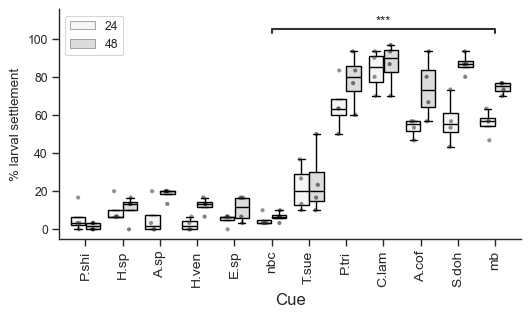

In [31]:
#Try plot but adding statistical annotations using 'statannot'

from statannot import add_stat_annotation

#Get ready to plot stylishly
sns.set(font="Arial")
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1)

#Make a neutral palette
# color palette as dictionary
mypalette = {24:"whitesmoke", 48:"gainsboro"}


#Data subset for 24 and 48 hpi
time_2448 = df[(df['time_after_induction']==24) | (df['time_after_induction']==48)]

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}


grped_bplot = sns.catplot(x='Abbreviation', 
                          y='%_crawl_coverslip',
                          hue="time_after_induction",
                          kind="box",
                          legend=False,
                          height=3, 
                          aspect=1.8,
                          palette= mypalette,
                          fliersize=0,
                          data=time_2448,
                          linewidth=1.0,
                         **PROPS);

# make grouped stripplot
grped_bplot = sns.stripplot(x='Abbreviation', 
                            y='%_crawl_coverslip', 
                            hue='time_after_induction',
                            jitter=True,
                            dodge=True, 
                            marker='o', 
                            palette='dark:black',
                            alpha=0.5,
                            size=3,
                            data=time_2448)
# how to remove redundant legends in Python
# Let us first get legend information from the plot object
handles, labels = grped_bplot.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:2], labels[0:2], loc='upper left')

#sns.despine()
bplot.set_ylim(0, 100)
plt.xlabel("Cue", fontsize=12)
plt.ylabel("% larval settlement")
plt.xticks(rotation=90, fontsize=10)

test_results=add_stat_annotation(grped_bplot, data=time_2448, x="Abbreviation", y="%_crawl_coverslip",                          
                                box_pairs=[("nbc", "mb")],
                                 test="Mann-Whitney", text_format='star',
                                loc='inside', verbose=2)
test_results                                                    